<a href="https://colab.research.google.com/github/rociavl/Brain_mask_segmentation_model/blob/main/Brain_mask_model_UNET_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain_mask_model_UNET

In [1]:
!pip install SimpleITK
!pip install numpy
!pip install torch
!pip install torchinfo
!pip install torchsummary
!pip install torchmetrics
!pip install torchvision
!pip install pytorch-lightning

In [2]:
!pip install monai

In [3]:
!pip install pynrrd
!pip install segmentation-models-pytorch --quiet

In [ ]:
pip list | grep -E 'torch|monai|numpy'


efficientnet_pytorch               0.7.1
monai                              1.4.0
numpy                              1.26.4
pytorch-lightning                  2.5.1
segmentation_models_pytorch        0.4.0
torch                              2.6.0+cu124
torchaudio                         2.6.0+cu124
torchinfo                          1.8.0
torchmetrics                       1.7.0
torchsummary                       1.5.1
torchvision                        0.21.0+cu124


In [ ]:
def get_paired_files(ct_path, mask_path):
    # Check if directories exist
    if not os.path.exists(ct_path):
        raise FileNotFoundError(f"CT directory not found: {ct_path}")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask directory not found: {mask_path}")

    print(f"Scanning CT directory: {ct_path}")
    print(f"Scanning mask directory: {mask_path}")

    # Get CT files
    ct_files = {f.split('_')[0]: f for f in os.listdir(ct_path) if f.endswith("_CT.nrrd")}
    print(f"Found {len(ct_files)} CT files")

    # Get mask files
    mask_files = {}
    for f in os.listdir(mask_path):
        if f.endswith("_mask_1.nrrd"):
            patient_id = f.split('_')[0]
            if patient_id not in mask_files:
                mask_files[patient_id] = []

            for i in range(1, 8):
                mask_filename = f"{patient_id}_mask_{i}.nrrd"
                if mask_filename in os.listdir(mask_path):
                    mask_files[patient_id].append(mask_filename)

    print(f"Found masks for {len(mask_files)} patients")

    # Pair CT files with their corresponding masks
    paired_files = [(ct_files[k], mask_files[k]) for k in ct_files if k in mask_files]
    print(f"Created {len(paired_files)} paired files")

    if len(paired_files) == 0:
        print("Warning: No paired files found!")
        # Print some sample filenames to help diagnose
        print("\nSample CT files:")
        for idx, f in enumerate(list(ct_files.values())[:5]):
            print(f"  {idx+1}. {f}")

        print("\nSample mask files:")
        for idx, (k, v) in enumerate(list(mask_files.items())[:5]):
            print(f"  {idx+1}. Patient {k}: {v[:2]}")

    return paired_files

In [4]:
# prompt: import drive mount

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import torch
import numpy as np
import nrrd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from monai.networks.nets import UNet
from monai.transforms import (
    Compose,
    ScaleIntensityRanged,
    RandFlipd,
    RandRotate90d,
    ToTensord,
    Activationsd,
    AsDiscreted,
    SpatialPadd,
    RandGaussianNoised,
)
from monai.losses import DiceCELoss, DiceLoss
from monai.metrics import DiceMetric
from monai.data import decollate_batch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class definition with binary mask approach
class BrainSegDataset(Dataset):
    def __init__(self, ct_path, mask_path, file_pairs, transform=None):
        self.ct_path = ct_path
        self.mask_path = mask_path
        self.file_pairs = file_pairs
        self.transform = transform

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        # Get file paths
        ct_file, mask_files = self.file_pairs[idx]
        ct_file_path = os.path.join(self.ct_path, ct_file)
        ct_data, _ = nrrd.read(ct_file_path)
        ct_tensor = torch.from_numpy(ct_data).float().unsqueeze(0)

        # Create a binary mask by thresholding the average of all masks
        if isinstance(mask_files, list):
            masks_data = []
            for mask_file in mask_files:
                mask_file_path = os.path.join(self.mask_path, mask_file)
                mask_data, _ = nrrd.read(mask_file_path)
                masks_data.append(mask_data)

            # Average the masks to create a probability map
            mask_data = np.mean(masks_data, axis=0)
            # Convert to binary (threshold at 0.5)
            mask_data = (mask_data > 0.5).astype(np.float32)
        else:
            mask_file_path = os.path.join(self.mask_path, mask_files)
            mask_data, _ = nrrd.read(mask_file_path)
            # Ensure it's binary
            mask_data = (mask_data > 0.5).astype(np.float32)

        mask_tensor = torch.from_numpy(mask_data).float().unsqueeze(0)

        data = {
            "image": ct_tensor,
            "mask": mask_tensor
        }

        if self.transform:
            transformed_data = self.transform(data)
            if isinstance(transformed_data, list):
                image = transformed_data[0]["image"]
                mask = transformed_data[0]["mask"]
            else:
                image = transformed_data["image"]
                mask = transformed_data["mask"]
            return image, mask

        return data["image"], data["mask"]

# Define transforms for whole volume processing
# Note: We'll pad smaller volumes to ensure consistent sizes for batch processing
def get_max_shape(file_pairs, ct_path):
    """Get maximum volume dimensions from the dataset for padding"""
    max_shape = [0, 0, 0]
    for ct_file, _ in file_pairs:
        ct_file_path = os.path.join(ct_path, ct_file)
        ct_data, _ = nrrd.read(ct_file_path)
        max_shape = [max(max_shape[i], ct_data.shape[i]) for i in range(3)]
    # Round up to nearest multiple of 16 for better GPU utilization
    max_shape = [((dim + 15) // 16) * 16 for dim in max_shape]
    return max_shape

# Define preprocessing and augmentation transforms
def create_transforms(file_pairs, ct_path, is_train=True):
    # Get max dimensions for padding
    max_shape = get_max_shape(file_pairs, ct_path)
    print(f"Maximum volume shape: {max_shape}")

    transforms = [
        # Scale intensity for CT scans
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-1000,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        # Pad to ensure consistent dimensions
        SpatialPadd(
            keys=["image", "mask"],
            spatial_size=max_shape,
            mode=("constant", "constant"),
            value=(0, 0),
        ),
    ]

    # Add augmentations only for training
    if is_train:
        transforms.extend([
            # Data augmentations
            RandFlipd(
                keys=["image", "mask"],
                spatial_axis=[0, 1, 2],
                prob=0.6,
            ),
            RandRotate90d(
                keys=["image", "mask"],
                prob=0.6,
                max_k=3,
            ),
            RandGaussianNoised(
                keys=["image"],
                prob=0.3,
                mean=0.0,
                std=0.1),
        ])

    transforms.append(ToTensord(keys=["image", "mask"]))

    return Compose(transforms)

# Define post-processing transforms
post_transforms = Compose([
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
])

# Function to pair CT files with mask files
def get_paired_files(ct_path, mask_path):
    # Check if directories exist
    if not os.path.exists(ct_path):
        raise FileNotFoundError(f"CT directory not found: {ct_path}")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask directory not found: {mask_path}")

    print(f"Scanning CT directory: {ct_path}")
    print(f"Scanning mask directory: {mask_path}")

    # Get CT files
    ct_files = {f.split('_')[0]: f for f in os.listdir(ct_path) if f.endswith("_CT.nrrd")}
    print(f"Found {len(ct_files)} CT files")

    # Get mask files
    mask_files = {}
    for f in os.listdir(mask_path):
        if f.endswith("_mask_1.nrrd"):
            patient_id = f.split('_')[0]
            if patient_id not in mask_files:
                mask_files[patient_id] = []

            for i in range(1, 8):
                mask_filename = f"{patient_id}_mask_{i}.nrrd"
                if mask_filename in os.listdir(mask_path):
                    mask_files[patient_id].append(mask_filename)

    print(f"Found masks for {len(mask_files)} patients")

    # Pair CT files with their corresponding masks
    paired_files = [(ct_files[k], mask_files[k]) for k in ct_files if k in mask_files]
    print(f"Created {len(paired_files)} paired files")

    if len(paired_files) == 0:
        print("Warning: No paired files found!")
        # Print some sample filenames to help diagnose
        print("\nSample CT files:")
        for idx, f in enumerate(list(ct_files.values())[:5]):
            print(f"  {idx+1}. {f}")

        print("\nSample mask files:")
        for idx, (k, v) in enumerate(list(mask_files.items())[:5]):
            print(f"  {idx+1}. Patient {k}: {v[:2]}")

    return paired_files

# Create improved model
def create_model():
    """Create 3D UNet model with improved architecture for binary segmentation"""
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,  # Binary segmentation
        channels=(32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        dropout=0.5,
        norm="instance",
        act="leakyrelu"
    ).to(device)

    return model

# Improved loss function for binary segmentation
class BinarySegLoss(torch.nn.Module):
    def __init__(self, dice_weight=0.8, bce_weight=0.2):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.dice_loss = DiceLoss(sigmoid=True)
        self.bce_loss = torch.nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        dice = self.dice_loss(outputs, targets)
        bce = self.bce_loss(outputs, targets)
        return self.dice_weight * dice + self.bce_weight * bce

# Modified training function for whole volumes
def train_epoch(model, dataloader, optimizer, loss_function, epoch):
    """Train for one epoch using full volumes"""
    model.train()
    epoch_loss = 0

    progress = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}")

    for step, (images, masks) in progress:
        images, masks = images.to(device), masks.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = loss_function(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Update statistics
        epoch_loss += loss.item()
        progress.set_postfix({"loss": loss.item()})

    return epoch_loss / (step + 1)

# Binary Dice metric
def dice_metric(pred, target, smooth=1e-5):
    """Calculate Dice score between binary prediction and target"""
    # Convert to binary
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

# Modified evaluation function for whole volumes
def evaluate(model, data_loader):
    model.eval()
    dice_scores = []
    dice_metric = DiceMetric(include_background=True, reduction="mean")

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)

            # Process the whole volume at once
            outputs = model(images)

            # Apply sigmoid and threshold for binary output
            binary_outputs = (torch.sigmoid(outputs) > 0.5).float()

            # Calculate dice score
            dice_metric(y_pred=binary_outputs, y=masks)

            # Also calculate for visualization
            batch_dice = dice_metric(binary_outputs, masks)
            dice_scores.append(batch_dice.item())

    avg_dice = dice_metric.aggregate().item()
    dice_metric.reset()

    return avg_dice

# Enhanced visualization function for binary masks
def save_prediction_visualization(image, mask, pred, patient_id, fold, epoch, output_dir="predictions_2_brain_mask"):
    """Save visualization of binary prediction results"""
    os.makedirs(output_dir, exist_ok=True)

    # Convert to numpy for visualization
    image_np = image[0, 0].cpu().numpy()  # First image, first channel
    mask_np = mask[0, 0].cpu().numpy()

    # Convert prediction to binary
    binary_pred_np = (pred[0, 0].cpu().numpy() > 0.5).astype(np.float32)

    # Get middle slice for each axis for visualization
    slice_x = image_np.shape[0] // 2
    slice_y = image_np.shape[1] // 2
    slice_z = image_np.shape[2] // 2

    # Create figure
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    # Set titles for columns
    axes[0, 0].set_title('Original Image')
    axes[0, 1].set_title('Ground Truth')
    axes[0, 2].set_title('Binary Prediction')

    # Row labels
    row_labels = ['Axial', 'Coronal', 'Sagittal']
    for i, label in enumerate(row_labels):
        axes[i, 0].set_ylabel(label, rotation=90, size='large')

    # Axial view (x-y plane)
    axes[0, 0].imshow(image_np[slice_x], cmap='gray')
    axes[0, 1].imshow(mask_np[slice_x], cmap='hot')
    axes[0, 2].imshow(image_np[slice_x], cmap='gray')
    axes[0, 2].imshow(binary_pred_np[slice_x], cmap='hot', alpha=0.5)

    # Coronal view (x-z plane)
    axes[1, 0].imshow(image_np[:, slice_y, :].T, cmap='gray')
    axes[1, 1].imshow(mask_np[:, slice_y, :].T, cmap='hot')
    axes[1, 2].imshow(image_np[:, slice_y, :].T, cmap='gray')
    axes[1, 2].imshow(binary_pred_np[:, slice_y, :].T, cmap='hot', alpha=0.5)

    # Sagittal view (y-z plane)
    axes[2, 0].imshow(image_np[:, :, slice_z].T, cmap='gray')
    axes[2, 1].imshow(mask_np[:, :, slice_z].T, cmap='hot')
    axes[2, 2].imshow(image_np[:, :, slice_z].T, cmap='gray')
    axes[2, 2].imshow(binary_pred_np[:, :, slice_z].T, cmap='hot', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/patient_{patient_id}_fold_{fold}_epoch_{epoch}_binary.png")
    plt.close()

    # Save a comparison of original vs binary prediction
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image_np[slice_x], cmap='gray')
    axes[0].set_title('CT Slice')

    axes[1].imshow(binary_pred_np[slice_x], cmap='hot')
    axes[1].set_title('Binary Mask')

    # Overlay
    axes[2].imshow(image_np[slice_x], cmap='gray')
    axes[2].imshow(binary_pred_np[slice_x], cmap='hot', alpha=0.5)
    axes[2].set_title('Overlay')

    plt.savefig(f"{output_dir}/patient_{patient_id}_fold_{fold}_epoch_{epoch}_comparison.png")
    plt.close()

# Modified cross-validation function with whole volume processing
def leave_one_out_cv(file_pairs, ct_dir, mask_dir, num_epochs=50, batch_size=1):
    """Implement leave-one-out cross-validation with whole volumes"""
    patient_ids = sorted(set(pair[0].split('_')[0] for pair in file_pairs))

    results = {
        "patient_id": [],
        "fold": [],
        "best_dice_score": []
    }

    for fold, test_patient in enumerate(patient_ids):
        print(f"\n{'='*50}")
        print(f"Starting fold {fold}, Test Patient: {test_patient}")
        print(f"{'='*50}")

        # Split data
        train_pairs = [pair for pair in file_pairs if pair[0].split('_')[0] != test_patient]
        test_pairs = [pair for pair in file_pairs if pair[0].split('_')[0] == test_patient]

        print(f"Training on {len(train_pairs)} pairs, Testing on {len(test_pairs)} pairs")

        # Create transforms for training
        train_transforms = create_transforms(train_pairs, ct_dir, is_train=True)
        test_transforms = create_transforms(test_pairs, ct_dir, is_train=False)

        # Create datasets
        train_ds = BrainSegDataset(
            ct_path=ct_dir,
            mask_path=mask_dir,
            file_pairs=train_pairs,
            transform=train_transforms
        )

        test_ds = BrainSegDataset(
            ct_path=ct_dir,
            mask_path=mask_dir,
            file_pairs=test_pairs,
            transform=test_transforms
        )

        # Create data loaders with smaller batch size for whole volumes
        train_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )

        test_loader = DataLoader(
            test_ds,
            batch_size=1,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )

        # Create model and optimizer
        model = create_model()
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        loss_function = BinarySegLoss(dice_weight=0.8, bce_weight=0.2)

        # Train and evaluate
        best_dice = 0.0
        patience_counter = 0
        patience_limit = 10  # Early stopping after 10 epochs without improvement

        for epoch in range(num_epochs):
            # Train
            train_loss = train_epoch(model, train_loader, optimizer, loss_function, epoch)
            print(f"Fold {fold}, Epoch {epoch}, Loss: {train_loss:.4f}")

            # Update learning rate
            scheduler.step(train_loss)

            # Evaluate every 5 epochs
            if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
                avg_dice = evaluate(model, test_loader)

                print(f"Fold {fold}, Epoch {epoch}, Test Patient {test_patient}, Dice: {avg_dice:.4f}")

                # Save checkpoint if best performance
                if avg_dice > best_dice:
                    best_dice = avg_dice
                    patience_counter = 0

                    torch.save({
                        'fold': fold,
                        'epoch': epoch,
                        'test_patient': test_patient,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'dice_score': best_dice
                    }, f"best_model_fold_{fold}_patient_{test_patient}.pt")

                    # Generate and save a visualization
                    model.eval()
                    with torch.no_grad():
                        for images, masks in test_loader:
                            images, masks = images.to(device), masks.to(device)

                            # Process whole volume
                            outputs = model(images)

                            # Get binary prediction
                            binary_outputs = (torch.sigmoid(outputs) > 0.5).float()

                            save_prediction_visualization(
                                images, masks, binary_outputs,
                                test_patient, fold, epoch
                            )
                            break  # Just do first test volume
                else:
                    patience_counter += 1

                # Early stopping
                if patience_counter >= patience_limit:
                    print(f"Early stopping at epoch {epoch} due to no improvement")
                    break

        # Record results
        results["patient_id"].append(test_patient)
        results["fold"].append(fold)
        results["best_dice_score"].append(best_dice)

        print(f"\nFold {fold} complete. Best Dice Score: {best_dice:.4f}")

    # Print overall results
    print("\nLeave-One-Out Cross-Validation Results:")
    print(f"Average Dice Score: {np.mean(results['best_dice_score']):.4f}")
    for i, patient in enumerate(results["patient_id"]):
        print(f"Patient {patient}: Dice Score = {results['best_dice_score'][i]:.4f}")

    # Save results
    np.save("loocv_results.npy", results)

    return results

# Enhanced inference function for whole volumes
def predict(model_path, ct_file_path, output_path=None, threshold=0.5):
    """
    Make prediction on a new CT scan using whole volume processing

    Args:
        model_path: Path to saved model
        ct_file_path: Path to CT scan file (.nrrd)
        output_path: Path to save binary segmentation output (.nrrd)
        threshold: Threshold for binary segmentation (default: 0.5)

    Returns:
        binary_segmentation: Binary mask of the brain segmentation (0 or 1)
    """
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    model = create_model()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load CT scan
    ct_data, header = nrrd.read(ct_file_path)
    ct_tensor = torch.from_numpy(ct_data).float().unsqueeze(0).unsqueeze(0).to(device)

    # Normalize CT scan
    ct_tensor = (ct_tensor.clamp(-1000, 1000) + 1000) / 2000

    # Get original shape for later cropping
    orig_shape = ct_data.shape

    # Check if padding is needed for the model
    pad_to_shape = None
    for dim_idx, dim_size in enumerate(orig_shape):
        if dim_size % 16 != 0:
            if pad_to_shape is None:
                pad_to_shape = list(orig_shape)
            pad_to_shape[dim_idx] = ((dim_size + 15) // 16) * 16

    # Apply padding if needed
    if pad_to_shape is not None:
        padding = []
        for orig_dim, pad_dim in zip(orig_shape, pad_to_shape):
            pad_amount = pad_dim - orig_dim
            padding.extend([0, pad_amount])

        # Pad the tensor
        ct_tensor = torch.nn.functional.pad(ct_tensor, padding, mode='constant', value=0)

    # Make prediction
    with torch.no_grad():
        # Process the whole volume
        output = model(ct_tensor)

        # Apply sigmoid to get probability map
        prob_map = torch.sigmoid(output)

        # Convert to binary mask
        binary_mask = (prob_map > threshold).float()

        # Crop back to original size if padding was applied
        if pad_to_shape is not None:
            binary_mask = binary_mask[:, :, :orig_shape[0], :orig_shape[1], :orig_shape[2]]

        binary_segmentation = binary_mask.cpu().numpy()[0, 0]

    # Save output if requested
    if output_path:
        # Convert to binary and save as NRRD
        binary_output = binary_segmentation.astype(np.uint8)
        nrrd.write(output_path, binary_output, header)

    return binary_segmentation

# Apply post-processing to improve binary mask quality
def post_process_mask(binary_mask, min_region_size=100):
    """
    Apply post-processing to improve binary mask quality

    Args:
        binary_mask: Binary mask from model prediction
        min_region_size: Minimum size of regions to keep

    Returns:
        processed_mask: Improved binary mask
    """
    from scipy import ndimage

    # Label connected components
    labeled_mask, num_features = ndimage.label(binary_mask)

    # Get component sizes
    component_sizes = np.bincount(labeled_mask.ravel())

    # Create a mask of components to keep (size > min_region_size)
    keep_components = np.zeros(component_sizes.shape, dtype=bool)
    keep_components[1:] = component_sizes[1:] > min_region_size  # Skip background (0)

    # Remove small components
    processed_mask = keep_components[labeled_mask]

    # Fill holes in 3D
    processed_mask = ndimage.binary_fill_holes(processed_mask)

    return processed_mask.astype(np.float32)

# Main execution
if __name__ == "__main__":
    # Set paths for CT and mask directories
    ct_dir = "/content/drive/MyDrive/TFG 💪🧠/Code/Modelos /Brain_mask_model/Dataset/CT"
    mask_dir = "/content/drive/MyDrive/TFG 💪🧠/Code/Modelos /Brain_mask_model/Dataset/MASK"

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    try:
        # Get pairs of CT files and mask files
        file_pairs = get_paired_files(ct_dir, mask_dir)
        print(f"Found {len(file_pairs)} paired files")

        if len(file_pairs) > 0:
            print(f"Example pair: {file_pairs[0]}")

            # Check memory usage of a typical volume
            example_ct, _ = file_pairs[0]
            example_ct_path = os.path.join(ct_dir, example_ct)
            ct_data, _ = nrrd.read(example_ct_path)
            print(f"Example CT shape: {ct_data.shape}, Memory usage: {ct_data.nbytes / (1024 * 1024):.2f} MB")

            # Check available GPU memory
            if torch.cuda.is_available():
                free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
                print(f"Available GPU memory: {free_mem / (1024 * 1024):.2f} MB")

            # Run leave-one-out cross-validation
            results = leave_one_out_cv(
                file_pairs=file_pairs,
                ct_dir=ct_dir,
                mask_dir=mask_dir,
                num_epochs=50,
                batch_size=1
            )

            # Example of inference with post-processing
            if results and len(results["patient_id"]) > 0:
                # Load best model
                best_fold = np.argmax(results["best_dice_score"])
                best_patient = results["patient_id"][best_fold]
                model_path = f"best_model_fold_{best_fold}_patient_{best_patient}.pt"

                # Get a test CT file
                test_ct = os.path.join(ct_dir, f"{best_patient}_CT.nrrd")
                output_path = f"{best_patient}_brain_mask.nrrd"

                # Run inference
                binary_mask = predict(model_path, test_ct, output_path)

                # Apply post-processing
                processed_mask = post_process_mask(binary_mask)

                # Save processed mask
                _, header = nrrd.read(test_ct)
                nrrd.write(f"{best_patient}_processed_brain_mask.nrrd", processed_mask, header)

                print(f"Saved binary mask to {output_path}")
                print(f"Saved post-processed mask to {best_patient}_processed_brain_mask.nrrd")
        else:
            print("No file pairs found. Please check your data directories.")
    except Exception as e:
        print(f"Error occurred: {e}")

Using device: cuda
Scanning CT directory: /content/drive/MyDrive/TFG 💪🧠/Code/Modelos /Brain_mask_model/Dataset/CT
Scanning mask directory: /content/drive/MyDrive/TFG 💪🧠/Code/Modelos /Brain_mask_model/Dataset/MASK
Found 6 CT files
Found masks for 6 patients
Created 6 paired files
Found 6 paired files
Example pair: ('patient1_CT.nrrd', ['patient1_mask_1.nrrd', 'patient1_mask_2.nrrd', 'patient1_mask_3.nrrd', 'patient1_mask_4.nrrd', 'patient1_mask_5.nrrd', 'patient1_mask_6.nrrd', 'patient1_mask_7.nrrd'])
Example CT shape: (256, 256, 256), Memory usage: 64.00 MB
Available GPU memory: 22692.88 MB

Starting fold 0, Test Patient: patient1
Training on 5 pairs, Testing on 1 pairs
Maximum volume shape: [256, 256, 256]
Maximum volume shape: [256, 256, 256]


Epoch 0: 100%|██████████| 5/5 [01:17<00:00, 15.55s/it, loss=0.853]


Fold 0, Epoch 0, Loss: 0.8592


Epoch 1: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it, loss=0.843]


Fold 0, Epoch 1, Loss: 0.8437


Epoch 2: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it, loss=0.823]


Fold 0, Epoch 2, Loss: 0.8344


Epoch 3: 100%|██████████| 5/5 [00:08<00:00,  1.78s/it, loss=0.821]


Fold 0, Epoch 3, Loss: 0.8282


Epoch 4: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.832]


Fold 0, Epoch 4, Loss: 0.8252
Fold 0, Epoch 4, Test Patient patient1, Dice: 0.4903


Epoch 5: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, loss=0.828]


Fold 0, Epoch 5, Loss: 0.8213


Epoch 6: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, loss=0.826]


Fold 0, Epoch 6, Loss: 0.8190


Epoch 7: 100%|██████████| 5/5 [00:10<00:00,  2.01s/it, loss=0.817]


Fold 0, Epoch 7, Loss: 0.8166


Epoch 8: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.821]


Fold 0, Epoch 8, Loss: 0.8147


Epoch 9: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.821]


Fold 0, Epoch 9, Loss: 0.8130
Fold 0, Epoch 9, Test Patient patient1, Dice: 0.6192


Epoch 10: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, loss=0.802]


Fold 0, Epoch 10, Loss: 0.8109


Epoch 11: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it, loss=0.801]


Fold 0, Epoch 11, Loss: 0.8094


Epoch 12: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.806]


Fold 0, Epoch 12, Loss: 0.8077


Epoch 13: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.799]


Fold 0, Epoch 13, Loss: 0.8065


Epoch 14: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, loss=0.811]


Fold 0, Epoch 14, Loss: 0.8042
Fold 0, Epoch 14, Test Patient patient1, Dice: 0.6862


Epoch 15: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.811]


Fold 0, Epoch 15, Loss: 0.8026


Epoch 16: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.802]


Fold 0, Epoch 16, Loss: 0.8016


Epoch 17: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it, loss=0.807]


Fold 0, Epoch 17, Loss: 0.7989


Epoch 18: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.799]


Fold 0, Epoch 18, Loss: 0.7975


Epoch 19: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.786]


Fold 0, Epoch 19, Loss: 0.7960
Fold 0, Epoch 19, Test Patient patient1, Dice: 0.7805


Epoch 20: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.798]


Fold 0, Epoch 20, Loss: 0.7946


Epoch 21: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.784]


Fold 0, Epoch 21, Loss: 0.7923


Epoch 22: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.793]


Fold 0, Epoch 22, Loss: 0.7919


Epoch 23: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.8]


Fold 0, Epoch 23, Loss: 0.7895


Epoch 24: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.788]


Fold 0, Epoch 24, Loss: 0.7870
Fold 0, Epoch 24, Test Patient patient1, Dice: 0.8305


Epoch 25: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.778]


Fold 0, Epoch 25, Loss: 0.7860


Epoch 26: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.784]


Fold 0, Epoch 26, Loss: 0.7872


Epoch 27: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.774]


Fold 0, Epoch 27, Loss: 0.7844


Epoch 28: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.773]


Fold 0, Epoch 28, Loss: 0.7816


Epoch 29: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.787]


Fold 0, Epoch 29, Loss: 0.7813
Fold 0, Epoch 29, Test Patient patient1, Dice: 0.8991


Epoch 30: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.779]


Fold 0, Epoch 30, Loss: 0.7782


Epoch 31: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.769]


Fold 0, Epoch 31, Loss: 0.7775


Epoch 32: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.787]


Fold 0, Epoch 32, Loss: 0.7753


Epoch 33: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.763]


Fold 0, Epoch 33, Loss: 0.7741


Epoch 34: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.774]


Fold 0, Epoch 34, Loss: 0.7718
Fold 0, Epoch 34, Test Patient patient1, Dice: 0.9169


Epoch 35: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it, loss=0.784]


Fold 0, Epoch 35, Loss: 0.7718


Epoch 36: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.76]


Fold 0, Epoch 36, Loss: 0.7700


Epoch 37: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.759]


Fold 0, Epoch 37, Loss: 0.7689


Epoch 38: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.759]


Fold 0, Epoch 38, Loss: 0.7674


Epoch 39: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.768]


Fold 0, Epoch 39, Loss: 0.7658
Fold 0, Epoch 39, Test Patient patient1, Dice: 0.9241


Epoch 40: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.768]


Fold 0, Epoch 40, Loss: 0.7646


Epoch 41: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, loss=0.755]


Fold 0, Epoch 41, Loss: 0.7644


Epoch 42: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.766]


Fold 0, Epoch 42, Loss: 0.7633


Epoch 43: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.752]


Fold 0, Epoch 43, Loss: 0.7617


Epoch 44: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it, loss=0.763]


Fold 0, Epoch 44, Loss: 0.7605
Fold 0, Epoch 44, Test Patient patient1, Dice: 0.9303


Epoch 45: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it, loss=0.763]


Fold 0, Epoch 45, Loss: 0.7596


Epoch 46: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.747]


Fold 0, Epoch 46, Loss: 0.7584


Epoch 47: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.746]


Fold 0, Epoch 47, Loss: 0.7574


Epoch 48: 100%|██████████| 5/5 [00:10<00:00,  2.10s/it, loss=0.759]


Fold 0, Epoch 48, Loss: 0.7569


Epoch 49: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.76]


Fold 0, Epoch 49, Loss: 0.7560
Fold 0, Epoch 49, Test Patient patient1, Dice: 0.9441

Fold 0 complete. Best Dice Score: 0.9441

Starting fold 1, Test Patient: patient2
Training on 5 pairs, Testing on 1 pairs
Maximum volume shape: [256, 256, 256]
Maximum volume shape: [256, 256, 256]


Epoch 0: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.881]


Fold 1, Epoch 0, Loss: 0.9015


Epoch 1: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it, loss=0.852]


Fold 1, Epoch 1, Loss: 0.8675


Epoch 2: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it, loss=0.834]


Fold 1, Epoch 2, Loss: 0.8439


Epoch 3: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, loss=0.819]


Fold 1, Epoch 3, Loss: 0.8320


Epoch 4: 100%|██████████| 5/5 [00:10<00:00,  2.01s/it, loss=0.815]


Fold 1, Epoch 4, Loss: 0.8229
Fold 1, Epoch 4, Test Patient patient2, Dice: 0.1368


Epoch 5: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, loss=0.813]


Fold 1, Epoch 5, Loss: 0.8192


Epoch 6: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.806]


Fold 1, Epoch 6, Loss: 0.8128


Epoch 7: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.798]


Fold 1, Epoch 7, Loss: 0.8093


Epoch 8: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.797]


Fold 1, Epoch 8, Loss: 0.8078


Epoch 9: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, loss=0.812]


Fold 1, Epoch 9, Loss: 0.8045
Fold 1, Epoch 9, Test Patient patient2, Dice: 0.1413


Epoch 10: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.809]


Fold 1, Epoch 10, Loss: 0.8020


Epoch 11: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, loss=0.798]


Fold 1, Epoch 11, Loss: 0.8012


Epoch 12: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, loss=0.808]


Fold 1, Epoch 12, Loss: 0.7986


Epoch 13: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.81]


Fold 1, Epoch 13, Loss: 0.7953


Epoch 14: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.784]


Fold 1, Epoch 14, Loss: 0.7934
Fold 1, Epoch 14, Test Patient patient2, Dice: 0.1417


Epoch 15: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.785]


Fold 1, Epoch 15, Loss: 0.7917


Epoch 16: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.783]


Fold 1, Epoch 16, Loss: 0.7890


Epoch 17: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.791]


Fold 1, Epoch 17, Loss: 0.7864


Epoch 18: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it, loss=0.778]


Fold 1, Epoch 18, Loss: 0.7854


Epoch 19: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.775]


Fold 1, Epoch 19, Loss: 0.7836
Fold 1, Epoch 19, Test Patient patient2, Dice: 0.1417


Epoch 20: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.776]


Fold 1, Epoch 20, Loss: 0.7825


Epoch 21: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.774]


Fold 1, Epoch 21, Loss: 0.7812


Epoch 22: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.793]


Fold 1, Epoch 22, Loss: 0.7824


Epoch 23: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.796]


Fold 1, Epoch 23, Loss: 0.7797


Epoch 24: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.769]


Fold 1, Epoch 24, Loss: 0.7782
Fold 1, Epoch 24, Test Patient patient2, Dice: 0.1417


Epoch 25: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it, loss=0.782]


Fold 1, Epoch 25, Loss: 0.7752


Epoch 26: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.768]


Fold 1, Epoch 26, Loss: 0.7741


Epoch 27: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, loss=0.778]


Fold 1, Epoch 27, Loss: 0.7735


Epoch 28: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.765]


Fold 1, Epoch 28, Loss: 0.7718


Epoch 29: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.767]


Fold 1, Epoch 29, Loss: 0.7711
Fold 1, Epoch 29, Test Patient patient2, Dice: 0.1418


Epoch 30: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, loss=0.761]


Fold 1, Epoch 30, Loss: 0.7687


Epoch 31: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.758]


Fold 1, Epoch 31, Loss: 0.7674


Epoch 32: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.761]


Fold 1, Epoch 32, Loss: 0.7668


Epoch 33: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.771]


Fold 1, Epoch 33, Loss: 0.7667


Epoch 34: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.758]


Fold 1, Epoch 34, Loss: 0.7646
Fold 1, Epoch 34, Test Patient patient2, Dice: 0.1418


Epoch 35: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it, loss=0.756]


Fold 1, Epoch 35, Loss: 0.7654


Epoch 36: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.762]


Fold 1, Epoch 36, Loss: 0.7648


Epoch 37: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.755]


Fold 1, Epoch 37, Loss: 0.7627


Epoch 38: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.767]


Fold 1, Epoch 38, Loss: 0.7617


Epoch 39: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it, loss=0.752]


Fold 1, Epoch 39, Loss: 0.7609
Fold 1, Epoch 39, Test Patient patient2, Dice: 0.1418


Epoch 40: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.752]


Fold 1, Epoch 40, Loss: 0.7597


Epoch 41: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.753]


Fold 1, Epoch 41, Loss: 0.7595


Epoch 42: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.752]


Fold 1, Epoch 42, Loss: 0.7589


Epoch 43: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it, loss=0.776]


Fold 1, Epoch 43, Loss: 0.7582


Epoch 44: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it, loss=0.749]


Fold 1, Epoch 44, Loss: 0.7577
Fold 1, Epoch 44, Test Patient patient2, Dice: 0.1418


Epoch 45: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, loss=0.777]


Fold 1, Epoch 45, Loss: 0.7577


Epoch 46: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.749]


Fold 1, Epoch 46, Loss: 0.7576


Epoch 47: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it, loss=0.761]


Fold 1, Epoch 47, Loss: 0.7565


Epoch 48: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.774]


Fold 1, Epoch 48, Loss: 0.7561


Epoch 49: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.749]


Fold 1, Epoch 49, Loss: 0.7549
Fold 1, Epoch 49, Test Patient patient2, Dice: 0.1418

Fold 1 complete. Best Dice Score: 0.1418

Starting fold 2, Test Patient: patient3
Training on 5 pairs, Testing on 1 pairs
Maximum volume shape: [256, 256, 256]
Maximum volume shape: [256, 256, 256]


Epoch 0: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.863]


Fold 2, Epoch 0, Loss: 0.8718


Epoch 1: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, loss=0.824]


Fold 2, Epoch 1, Loss: 0.8407


Epoch 2: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.827]


Fold 2, Epoch 2, Loss: 0.8244


Epoch 3: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.799]


Fold 2, Epoch 3, Loss: 0.8137


Epoch 4: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it, loss=0.812]


Fold 2, Epoch 4, Loss: 0.8070
Fold 2, Epoch 4, Test Patient patient3, Dice: 0.6218


Epoch 5: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.806]


Fold 2, Epoch 5, Loss: 0.8015


Epoch 6: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.79]


Fold 2, Epoch 6, Loss: 0.7962


Epoch 7: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.797]


Fold 2, Epoch 7, Loss: 0.7945


Epoch 8: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it, loss=0.783]


Fold 2, Epoch 8, Loss: 0.7913


Epoch 9: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.774]


Fold 2, Epoch 9, Loss: 0.7869
Fold 2, Epoch 9, Test Patient patient3, Dice: 0.7515


Epoch 10: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.792]


Fold 2, Epoch 10, Loss: 0.7857


Epoch 11: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.776]


Fold 2, Epoch 11, Loss: 0.7835


Epoch 12: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.787]


Fold 2, Epoch 12, Loss: 0.7804


Epoch 13: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.775]


Fold 2, Epoch 13, Loss: 0.7748


Epoch 14: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.779]


Fold 2, Epoch 14, Loss: 0.7766
Fold 2, Epoch 14, Test Patient patient3, Dice: 0.8727


Epoch 15: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.781]


Fold 2, Epoch 15, Loss: 0.7731


Epoch 16: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.766]


Fold 2, Epoch 16, Loss: 0.7724


Epoch 17: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.775]


Fold 2, Epoch 17, Loss: 0.7703


Epoch 18: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.773]


Fold 2, Epoch 18, Loss: 0.7673


Epoch 19: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.776]


Fold 2, Epoch 19, Loss: 0.7669
Fold 2, Epoch 19, Test Patient patient3, Dice: 0.9002


Epoch 20: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, loss=0.761]


Fold 2, Epoch 20, Loss: 0.7678


Epoch 21: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.769]


Fold 2, Epoch 21, Loss: 0.7652


Epoch 22: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.768]


Fold 2, Epoch 22, Loss: 0.7635


Epoch 23: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.762]


Fold 2, Epoch 23, Loss: 0.7616


Epoch 24: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.749]


Fold 2, Epoch 24, Loss: 0.7610
Fold 2, Epoch 24, Test Patient patient3, Dice: 0.8966


Epoch 25: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it, loss=0.771]


Fold 2, Epoch 25, Loss: 0.7585


Epoch 26: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.746]


Fold 2, Epoch 26, Loss: 0.7566


Epoch 27: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.759]


Fold 2, Epoch 27, Loss: 0.7549


Epoch 28: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.766]


Fold 2, Epoch 28, Loss: 0.7550


Epoch 29: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.756]


Fold 2, Epoch 29, Loss: 0.7530
Fold 2, Epoch 29, Test Patient patient3, Dice: 0.9144


Epoch 30: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.74]


Fold 2, Epoch 30, Loss: 0.7513


Epoch 31: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.74]


Fold 2, Epoch 31, Loss: 0.7504


Epoch 32: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.737]


Fold 2, Epoch 32, Loss: 0.7490


Epoch 33: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.75]


Fold 2, Epoch 33, Loss: 0.7486


Epoch 34: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.736]


Fold 2, Epoch 34, Loss: 0.7477
Fold 2, Epoch 34, Test Patient patient3, Dice: 0.9233


Epoch 35: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.752]


Fold 2, Epoch 35, Loss: 0.7465


Epoch 36: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it, loss=0.759]


Fold 2, Epoch 36, Loss: 0.7454


Epoch 37: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.759]


Fold 2, Epoch 37, Loss: 0.7454


Epoch 38: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.746]


Fold 2, Epoch 38, Loss: 0.7440


Epoch 39: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.748]


Fold 2, Epoch 39, Loss: 0.7432
Fold 2, Epoch 39, Test Patient patient3, Dice: 0.9228


Epoch 40: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, loss=0.756]


Fold 2, Epoch 40, Loss: 0.7419


Epoch 41: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.747]


Fold 2, Epoch 41, Loss: 0.7414


Epoch 42: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.747]


Fold 2, Epoch 42, Loss: 0.7407


Epoch 43: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.728]


Fold 2, Epoch 43, Loss: 0.7397


Epoch 44: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.743]


Fold 2, Epoch 44, Loss: 0.7396
Fold 2, Epoch 44, Test Patient patient3, Dice: 0.9163


Epoch 45: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.74]


Fold 2, Epoch 45, Loss: 0.7384


Epoch 46: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.739]


Fold 2, Epoch 46, Loss: 0.7376


Epoch 47: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.739]


Fold 2, Epoch 47, Loss: 0.7375


Epoch 48: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.726]


Fold 2, Epoch 48, Loss: 0.7365


Epoch 49: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it, loss=0.725]


Fold 2, Epoch 49, Loss: 0.7363
Fold 2, Epoch 49, Test Patient patient3, Dice: 0.9225

Fold 2 complete. Best Dice Score: 0.9233

Starting fold 3, Test Patient: patient4
Training on 5 pairs, Testing on 1 pairs
Maximum volume shape: [256, 256, 256]
Maximum volume shape: [256, 256, 256]


Epoch 0: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.866]


Fold 3, Epoch 0, Loss: 0.8756


Epoch 1: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.832]


Fold 3, Epoch 1, Loss: 0.8476


Epoch 2: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.834]


Fold 3, Epoch 2, Loss: 0.8337


Epoch 3: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.81]


Fold 3, Epoch 3, Loss: 0.8205


Epoch 4: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.815]


Fold 3, Epoch 4, Loss: 0.8177
Fold 3, Epoch 4, Test Patient patient4, Dice: 0.3351


Epoch 5: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, loss=0.808]


Fold 3, Epoch 5, Loss: 0.8144


Epoch 6: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.806]


Fold 3, Epoch 6, Loss: 0.8082


Epoch 7: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.794]


Fold 3, Epoch 7, Loss: 0.8052


Epoch 8: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.809]


Fold 3, Epoch 8, Loss: 0.8031


Epoch 9: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it, loss=0.798]


Fold 3, Epoch 9, Loss: 0.7998
Fold 3, Epoch 9, Test Patient patient4, Dice: 0.4336


Epoch 10: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.807]


Fold 3, Epoch 10, Loss: 0.7957


Epoch 11: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.783]


Fold 3, Epoch 11, Loss: 0.7925


Epoch 12: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.793]


Fold 3, Epoch 12, Loss: 0.7914


Epoch 13: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.787]


Fold 3, Epoch 13, Loss: 0.7883


Epoch 14: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.776]


Fold 3, Epoch 14, Loss: 0.7873
Fold 3, Epoch 14, Test Patient patient4, Dice: 0.5767


Epoch 15: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.793]


Fold 3, Epoch 15, Loss: 0.7845


Epoch 16: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.774]


Fold 3, Epoch 16, Loss: 0.7821


Epoch 17: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.772]


Fold 3, Epoch 17, Loss: 0.7798


Epoch 18: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, loss=0.769]


Fold 3, Epoch 18, Loss: 0.7807


Epoch 19: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.767]


Fold 3, Epoch 19, Loss: 0.7778
Fold 3, Epoch 19, Test Patient patient4, Dice: 0.7035


Epoch 20: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.767]


Fold 3, Epoch 20, Loss: 0.7810


Epoch 21: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it, loss=0.777]


Fold 3, Epoch 21, Loss: 0.7802


Epoch 22: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, loss=0.763]


Fold 3, Epoch 22, Loss: 0.7776


Epoch 23: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, loss=0.772]


Fold 3, Epoch 23, Loss: 0.7744


Epoch 24: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, loss=0.761]


Fold 3, Epoch 24, Loss: 0.7733
Fold 3, Epoch 24, Test Patient patient4, Dice: 0.7996


Epoch 25: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.779]


Fold 3, Epoch 25, Loss: 0.7708


Epoch 26: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.776]


Fold 3, Epoch 26, Loss: 0.7695


Epoch 27: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.761]


Fold 3, Epoch 27, Loss: 0.7690


Epoch 28: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.773]


Fold 3, Epoch 28, Loss: 0.7678


Epoch 29: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, loss=0.767]


Fold 3, Epoch 29, Loss: 0.7658
Fold 3, Epoch 29, Test Patient patient4, Dice: 0.7771


Epoch 30: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.767]


Fold 3, Epoch 30, Loss: 0.7656


Epoch 31: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.766]


Fold 3, Epoch 31, Loss: 0.7640


Epoch 32: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.768]


Fold 3, Epoch 32, Loss: 0.7623


Epoch 33: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.749]


Fold 3, Epoch 33, Loss: 0.7600


Epoch 34: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it, loss=0.763]


Fold 3, Epoch 34, Loss: 0.7603
Fold 3, Epoch 34, Test Patient patient4, Dice: 0.8719


Epoch 35: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.747]


Fold 3, Epoch 35, Loss: 0.7584


Epoch 36: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.76]


Fold 3, Epoch 36, Loss: 0.7578


Epoch 37: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.747]


Fold 3, Epoch 37, Loss: 0.7585


Epoch 38: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.76]


Fold 3, Epoch 38, Loss: 0.7569


Epoch 39: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.767]


Fold 3, Epoch 39, Loss: 0.7555
Fold 3, Epoch 39, Test Patient patient4, Dice: 0.8929


Epoch 40: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.757]


Fold 3, Epoch 40, Loss: 0.7543


Epoch 41: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.742]


Fold 3, Epoch 41, Loss: 0.7538


Epoch 42: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.742]


Fold 3, Epoch 42, Loss: 0.7524


Epoch 43: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.754]


Fold 3, Epoch 43, Loss: 0.7520


Epoch 44: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.755]


Fold 3, Epoch 44, Loss: 0.7515
Fold 3, Epoch 44, Test Patient patient4, Dice: 0.8843


Epoch 45: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.752]


Fold 3, Epoch 45, Loss: 0.7499


Epoch 46: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.763]


Fold 3, Epoch 46, Loss: 0.7499


Epoch 47: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.763]


Fold 3, Epoch 47, Loss: 0.7490


Epoch 48: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.753]


Fold 3, Epoch 48, Loss: 0.7482


Epoch 49: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.737]


Fold 3, Epoch 49, Loss: 0.7477
Fold 3, Epoch 49, Test Patient patient4, Dice: 0.8957

Fold 3 complete. Best Dice Score: 0.8957

Starting fold 4, Test Patient: patient5
Training on 5 pairs, Testing on 1 pairs
Maximum volume shape: [256, 256, 256]
Maximum volume shape: [256, 256, 256]


Epoch 0: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.879]


Fold 4, Epoch 0, Loss: 0.8785


Epoch 1: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.86]


Fold 4, Epoch 1, Loss: 0.8559


Epoch 2: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.834]


Fold 4, Epoch 2, Loss: 0.8434


Epoch 3: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.848]


Fold 4, Epoch 3, Loss: 0.8369


Epoch 4: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it, loss=0.826]


Fold 4, Epoch 4, Loss: 0.8334
Fold 4, Epoch 4, Test Patient patient5, Dice: 0.1266


Epoch 5: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.823]


Fold 4, Epoch 5, Loss: 0.8302


Epoch 6: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.824]


Fold 4, Epoch 6, Loss: 0.8278


Epoch 7: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it, loss=0.821]


Fold 4, Epoch 7, Loss: 0.8262


Epoch 8: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.818]


Fold 4, Epoch 8, Loss: 0.8252


Epoch 9: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.825]


Fold 4, Epoch 9, Loss: 0.8224
Fold 4, Epoch 9, Test Patient patient5, Dice: 0.1278


Epoch 10: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.818]


Fold 4, Epoch 10, Loss: 0.8210


Epoch 11: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.813]


Fold 4, Epoch 11, Loss: 0.8185


Epoch 12: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.82]


Fold 4, Epoch 12, Loss: 0.8180


Epoch 13: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.81]


Fold 4, Epoch 13, Loss: 0.8156


Epoch 14: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.825]


Fold 4, Epoch 14, Loss: 0.8145
Fold 4, Epoch 14, Test Patient patient5, Dice: 0.1335


Epoch 15: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.808]


Fold 4, Epoch 15, Loss: 0.8124


Epoch 16: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it, loss=0.816]


Fold 4, Epoch 16, Loss: 0.8127


Epoch 17: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, loss=0.802]


Fold 4, Epoch 17, Loss: 0.8098


Epoch 18: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, loss=0.805]


Fold 4, Epoch 18, Loss: 0.8081


Epoch 19: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it, loss=0.801]


Fold 4, Epoch 19, Loss: 0.8073
Fold 4, Epoch 19, Test Patient patient5, Dice: 0.1358


Epoch 20: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it, loss=0.799]


Fold 4, Epoch 20, Loss: 0.8054


Epoch 21: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.798]


Fold 4, Epoch 21, Loss: 0.8032


Epoch 22: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.797]


Fold 4, Epoch 22, Loss: 0.8019


Epoch 23: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.796]


Fold 4, Epoch 23, Loss: 0.8030


Epoch 24: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, loss=0.804]


Fold 4, Epoch 24, Loss: 0.8009
Fold 4, Epoch 24, Test Patient patient5, Dice: 0.1393


Epoch 25: 100%|██████████| 5/5 [00:08<00:00,  1.80s/it, loss=0.811]


Fold 4, Epoch 25, Loss: 0.7975


Epoch 26: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it, loss=0.801]


Fold 4, Epoch 26, Loss: 0.7964


Epoch 27: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it, loss=0.788]


Fold 4, Epoch 27, Loss: 0.7944


Epoch 28: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, loss=0.8]


Fold 4, Epoch 28, Loss: 0.7938


Epoch 29: 100%|██████████| 5/5 [00:10<00:00,  2.01s/it, loss=0.787]


Fold 4, Epoch 29, Loss: 0.7924
Fold 4, Epoch 29, Test Patient patient5, Dice: 0.1420


Epoch 30: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it, loss=0.783]


Fold 4, Epoch 30, Loss: 0.7914


Epoch 31: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.781]


Fold 4, Epoch 31, Loss: 0.7886


Epoch 32: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.8]


Fold 4, Epoch 32, Loss: 0.7876


Epoch 33: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it, loss=0.791]


Fold 4, Epoch 33, Loss: 0.7873


Epoch 34: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.776]


Fold 4, Epoch 34, Loss: 0.7837
Fold 4, Epoch 34, Test Patient patient5, Dice: 0.1423


Epoch 35: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.79]


Fold 4, Epoch 35, Loss: 0.7837


Epoch 36: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.775]


Fold 4, Epoch 36, Loss: 0.7826


Epoch 37: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, loss=0.784]


Fold 4, Epoch 37, Loss: 0.7809


Epoch 38: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.794]


Fold 4, Epoch 38, Loss: 0.7795


Epoch 39: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.77]


Fold 4, Epoch 39, Loss: 0.7789
Fold 4, Epoch 39, Test Patient patient5, Dice: 0.1423


Epoch 40: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.781]


Fold 4, Epoch 40, Loss: 0.7770


Epoch 41: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.768]


Fold 4, Epoch 41, Loss: 0.7761


Epoch 42: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.768]


Fold 4, Epoch 42, Loss: 0.7741


Epoch 43: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.765]


Fold 4, Epoch 43, Loss: 0.7733


Epoch 44: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.763]


Fold 4, Epoch 44, Loss: 0.7713
Fold 4, Epoch 44, Test Patient patient5, Dice: 0.1427


Epoch 45: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.764]


Fold 4, Epoch 45, Loss: 0.7703


Epoch 46: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, loss=0.761]


Fold 4, Epoch 46, Loss: 0.7692


Epoch 47: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it, loss=0.783]


Fold 4, Epoch 47, Loss: 0.7682


Epoch 48: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.76]


Fold 4, Epoch 48, Loss: 0.7669


Epoch 49: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.774]


Fold 4, Epoch 49, Loss: 0.7662
Fold 4, Epoch 49, Test Patient patient5, Dice: 0.1426

Fold 4 complete. Best Dice Score: 0.1427

Starting fold 5, Test Patient: patient8
Training on 5 pairs, Testing on 1 pairs
Maximum volume shape: [256, 256, 256]
Maximum volume shape: [256, 256, 256]


Epoch 0: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.898]


Fold 5, Epoch 0, Loss: 0.9116


Epoch 1: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.854]


Fold 5, Epoch 1, Loss: 0.8702


Epoch 2: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.835]


Fold 5, Epoch 2, Loss: 0.8461


Epoch 3: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it, loss=0.822]


Fold 5, Epoch 3, Loss: 0.8341


Epoch 4: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, loss=0.817]


Fold 5, Epoch 4, Loss: 0.8258
Fold 5, Epoch 4, Test Patient patient8, Dice: 0.1310


Epoch 5: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.814]


Fold 5, Epoch 5, Loss: 0.8190


Epoch 6: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.818]


Fold 5, Epoch 6, Loss: 0.8169


Epoch 7: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.815]


Fold 5, Epoch 7, Loss: 0.8116


Epoch 8: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, loss=0.795]


Fold 5, Epoch 8, Loss: 0.8059


Epoch 9: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.799]


Fold 5, Epoch 9, Loss: 0.8060
Fold 5, Epoch 9, Test Patient patient8, Dice: 0.1309


Epoch 10: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it, loss=0.791]


Fold 5, Epoch 10, Loss: 0.8012


Epoch 11: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.79]


Fold 5, Epoch 11, Loss: 0.8002


Epoch 12: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.806]


Fold 5, Epoch 12, Loss: 0.7954


Epoch 13: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.799]


Fold 5, Epoch 13, Loss: 0.7924


Epoch 14: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, loss=0.781]


Fold 5, Epoch 14, Loss: 0.7896
Fold 5, Epoch 14, Test Patient patient8, Dice: 0.1309


Epoch 15: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.795]


Fold 5, Epoch 15, Loss: 0.7858


Epoch 16: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.791]


Fold 5, Epoch 16, Loss: 0.7823


Epoch 17: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.778]


Fold 5, Epoch 17, Loss: 0.7827


Epoch 18: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it, loss=0.774]


Fold 5, Epoch 18, Loss: 0.7798


Epoch 19: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.768]


Fold 5, Epoch 19, Loss: 0.7773
Fold 5, Epoch 19, Test Patient patient8, Dice: 0.1309


Epoch 20: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.784]


Fold 5, Epoch 20, Loss: 0.7757


Epoch 21: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it, loss=0.775]


Fold 5, Epoch 21, Loss: 0.7785


Epoch 22: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.772]


Fold 5, Epoch 22, Loss: 0.7755


Epoch 23: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.777]


Fold 5, Epoch 23, Loss: 0.7773


Epoch 24: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.767]


Fold 5, Epoch 24, Loss: 0.7729
Fold 5, Epoch 24, Test Patient patient8, Dice: 0.1309


Epoch 25: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it, loss=0.768]


Fold 5, Epoch 25, Loss: 0.7734


Epoch 26: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it, loss=0.765]


Fold 5, Epoch 26, Loss: 0.7689


Epoch 27: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it, loss=0.775]


Fold 5, Epoch 27, Loss: 0.7681


Epoch 28: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, loss=0.758]


Fold 5, Epoch 28, Loss: 0.7651


Epoch 29: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it, loss=0.759]


Fold 5, Epoch 29, Loss: 0.7642
Fold 5, Epoch 29, Test Patient patient8, Dice: 0.1309


Epoch 30: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.773]


Fold 5, Epoch 30, Loss: 0.7636


Epoch 31: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.756]


Fold 5, Epoch 31, Loss: 0.7619


Epoch 32: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.755]


Fold 5, Epoch 32, Loss: 0.7616


Epoch 33: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.756]


Fold 5, Epoch 33, Loss: 0.7605


Epoch 34: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, loss=0.768]


Fold 5, Epoch 34, Loss: 0.7608
Fold 5, Epoch 34, Test Patient patient8, Dice: 0.1310


Epoch 35: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.755]


Fold 5, Epoch 35, Loss: 0.7590


Epoch 36: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, loss=0.753]


Fold 5, Epoch 36, Loss: 0.7595


Epoch 37: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.766]


Fold 5, Epoch 37, Loss: 0.7583


Epoch 38: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.769]


Fold 5, Epoch 38, Loss: 0.7576


Epoch 39: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.75]


Fold 5, Epoch 39, Loss: 0.7574
Fold 5, Epoch 39, Test Patient patient8, Dice: 0.1310


Epoch 40: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, loss=0.75]


Fold 5, Epoch 40, Loss: 0.7562


Epoch 41: 100%|██████████| 5/5 [00:10<00:00,  2.05s/it, loss=0.751]


Fold 5, Epoch 41, Loss: 0.7557


Epoch 42: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, loss=0.761]


Fold 5, Epoch 42, Loss: 0.7552


Epoch 43: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it, loss=0.748]


Fold 5, Epoch 43, Loss: 0.7549


Epoch 44: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it, loss=0.747]


Fold 5, Epoch 44, Loss: 0.7538
Fold 5, Epoch 44, Test Patient patient8, Dice: 0.1310


Epoch 45: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it, loss=0.747]


Fold 5, Epoch 45, Loss: 0.7537


Epoch 46: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, loss=0.764]


Fold 5, Epoch 46, Loss: 0.7536


Epoch 47: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it, loss=0.749]


Fold 5, Epoch 47, Loss: 0.7540


Epoch 48: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, loss=0.746]


Fold 5, Epoch 48, Loss: 0.7532


Epoch 49: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, loss=0.747]


Fold 5, Epoch 49, Loss: 0.7541
Fold 5, Epoch 49, Test Patient patient8, Dice: 0.1310

Fold 5 complete. Best Dice Score: 0.1310

Leave-One-Out Cross-Validation Results:
Average Dice Score: 0.5298
Patient patient1: Dice Score = 0.9441
Patient patient2: Dice Score = 0.1418
Patient patient3: Dice Score = 0.9233
Patient patient4: Dice Score = 0.8957
Patient patient5: Dice Score = 0.1427
Patient patient8: Dice Score = 0.1310
Saved binary mask to patient1_brain_mask.nrrd
Saved post-processed mask to patient1_processed_brain_mask.nrrd


patient1_fold_0_epoch_24_comparison

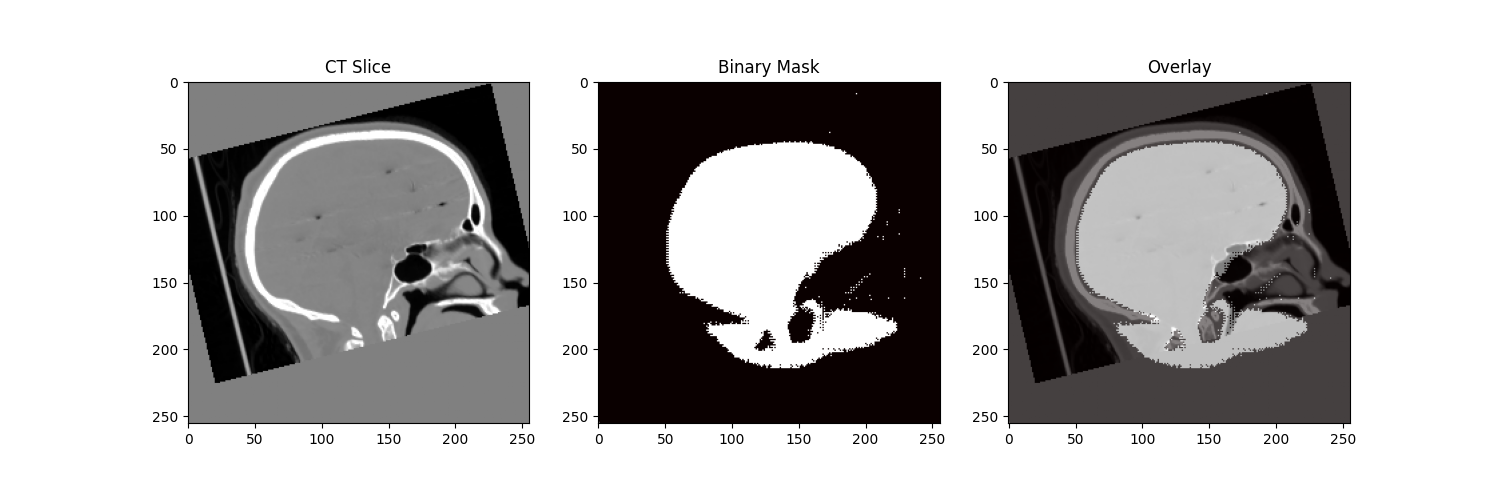

In [73]:
Image('/content/predictions_2_brain_mask/patient_patient1_fold_0_epoch_24_comparison.png')


patient4_fold_3_epoch_34_comparison

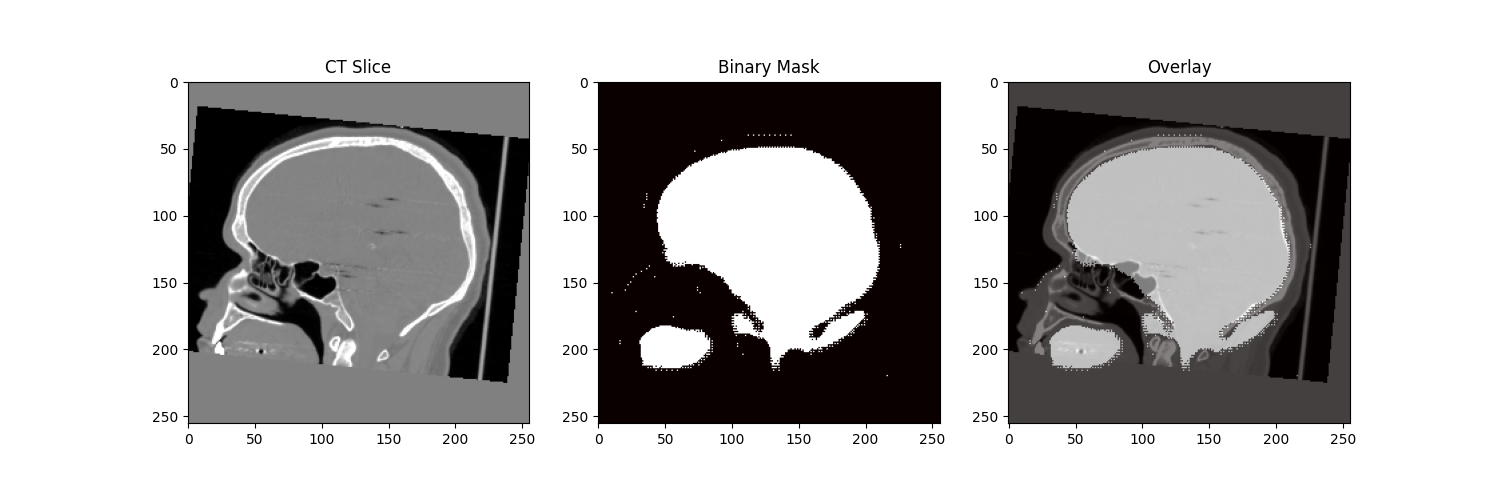

In [74]:
Image('/content/predictions_2_brain_mask/patient_patient4_fold_3_epoch_34_comparison.png')

## Visualization of model

In [34]:
def predict_final(model_path, ct_file_path, output_path=None, threshold=0.5):
    model = create_model()
    checkpoint = torch.load(model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model.eval()

    # Load CT scan
    ct_data, header = nrrd.read(ct_file_path)
    ct_tensor = torch.from_numpy(ct_data).float().unsqueeze(0).unsqueeze(0).to(device)

    # Normalize CT scan
    ct_tensor = (ct_tensor.clamp(-1000, 1000) + 1000) / 2000

    # Get original shape for later cropping
    orig_shape = ct_data.shape

    # Check if padding is needed for the model
    pad_to_shape = None
    for dim_idx, dim_size in enumerate(orig_shape):
        if dim_size % 16 != 0:
            if pad_to_shape is None:
                pad_to_shape = list(orig_shape)
            pad_to_shape[dim_idx] = ((dim_size + 15) // 16) * 16

    # Apply padding if needed
    if pad_to_shape is not None:
        padding = []
        for orig_dim, pad_dim in zip(orig_shape, pad_to_shape):
            pad_amount = pad_dim - orig_dim
            padding.extend([0, pad_amount])

        # Pad the tensor
        ct_tensor = torch.nn.functional.pad(ct_tensor, padding, mode='constant', value=0)

    # Make prediction
    with torch.no_grad():
        # Process the whole volume
        output = model(ct_tensor)

        # Apply sigmoid to get probability map
        prob_map = torch.sigmoid(output)

        # Convert to binary mask
        binary_mask = (prob_map > threshold).float()

        # Crop back to original size if padding was applied
        if pad_to_shape is not None:
            binary_mask = binary_mask[:, :, :orig_shape[0], :orig_shape[1], :orig_shape[2]]

        binary_segmentation = binary_mask.cpu().numpy()[0, 0]

    # Save output if requested
    if output_path:
        # Convert to binary and save as NRRD
        binary_output = binary_segmentation.astype(np.uint8)
        nrrd.write(output_path, binary_output, header)

    return binary_segmentation

## Visualization of best model in LOOCV

In [33]:
def load_and_visualize_failures(patient_id, ct_dir, mask_dir, model_path, paired_files, output_dir="failure_analysis"):
    # Find the specific pair for this patient
    patient_pair = None
    for ct_file, mask_files in paired_files:
        if ct_file.startswith(patient_id):
            patient_pair = (ct_file, mask_files)
            break

    if not patient_pair:
        raise ValueError(f"No data found for patient {patient_id}")

    # Load CT scan
    ct_path = os.path.join(ct_dir, patient_pair[0])
    ct_data, _ = nrrd.read(ct_path)

    # Load and process masks
    if isinstance(patient_pair[1], list):
        masks_data = []
        for mask_file in patient_pair[1]:
            mask_path = os.path.join(mask_dir, mask_file)
            mask_data, _ = nrrd.read(mask_path)
            masks_data.append(mask_data)
        combined_mask = np.mean(masks_data, axis=0)
        gt_mask = (combined_mask > 0.5).astype(np.float32)
    else:
        mask_path = os.path.join(mask_dir, patient_pair[1])
        gt_mask, _ = nrrd.read(mask_path)
        gt_mask = (gt_mask > 0.5).astype(np.float32)

    # Get model prediction
    pred_mask = predict_final(model_path, ct_path)

    # Visualize and save to dedicated folder
    save_prediction_visualization(
        torch.from_numpy(ct_data).unsqueeze(0).unsqueeze(0).float(),
        torch.from_numpy(gt_mask).unsqueeze(0).unsqueeze(0).float(),
        torch.from_numpy(pred_mask).unsqueeze(0).unsqueeze(0).float(),
        patient_id,
        fold=0,
        epoch=0,
        output_dir=output_dir  # Add this parameter to your visualization function
    )

# Create dedicated output directory
failure_dir = os.path.join(os.path.dirname(model_path), "failure_analysis")
os.makedirs(failure_dir, exist_ok=True)

# Single directory scan
ct_directory = "/content/drive/MyDrive/TFG 💪🧠/Code/Modelos /Brain_mask_model/Dataset/CT"
mask_directory = "/content/drive/MyDrive/TFG 💪🧠/Code/Modelos /Brain_mask_model/Dataset/MASK"
model_path = "/content/predictions_2_brain_mask/best_model_fold_0_patient_patient1.pt"

# Get paired files ONCE
paired_files = get_paired_files(ct_directory, mask_directory)

# Process failures
for pid in ["patient2", "patient5", "patient8"]:
    load_and_visualize_failures(
        patient_id=pid,
        ct_dir=ct_directory,
        mask_dir=mask_directory,
        model_path=model_path,
        paired_files=paired_files,
        output_dir=failure_dir
    )

Scanning CT directory: /content/drive/MyDrive/TFG 💪🧠/Code/Modelos /Brain_mask_model/Dataset/CT
Scanning mask directory: /content/drive/MyDrive/TFG 💪🧠/Code/Modelos /Brain_mask_model/Dataset/MASK
Found 6 CT files
Found masks for 6 patients
Created 6 paired files


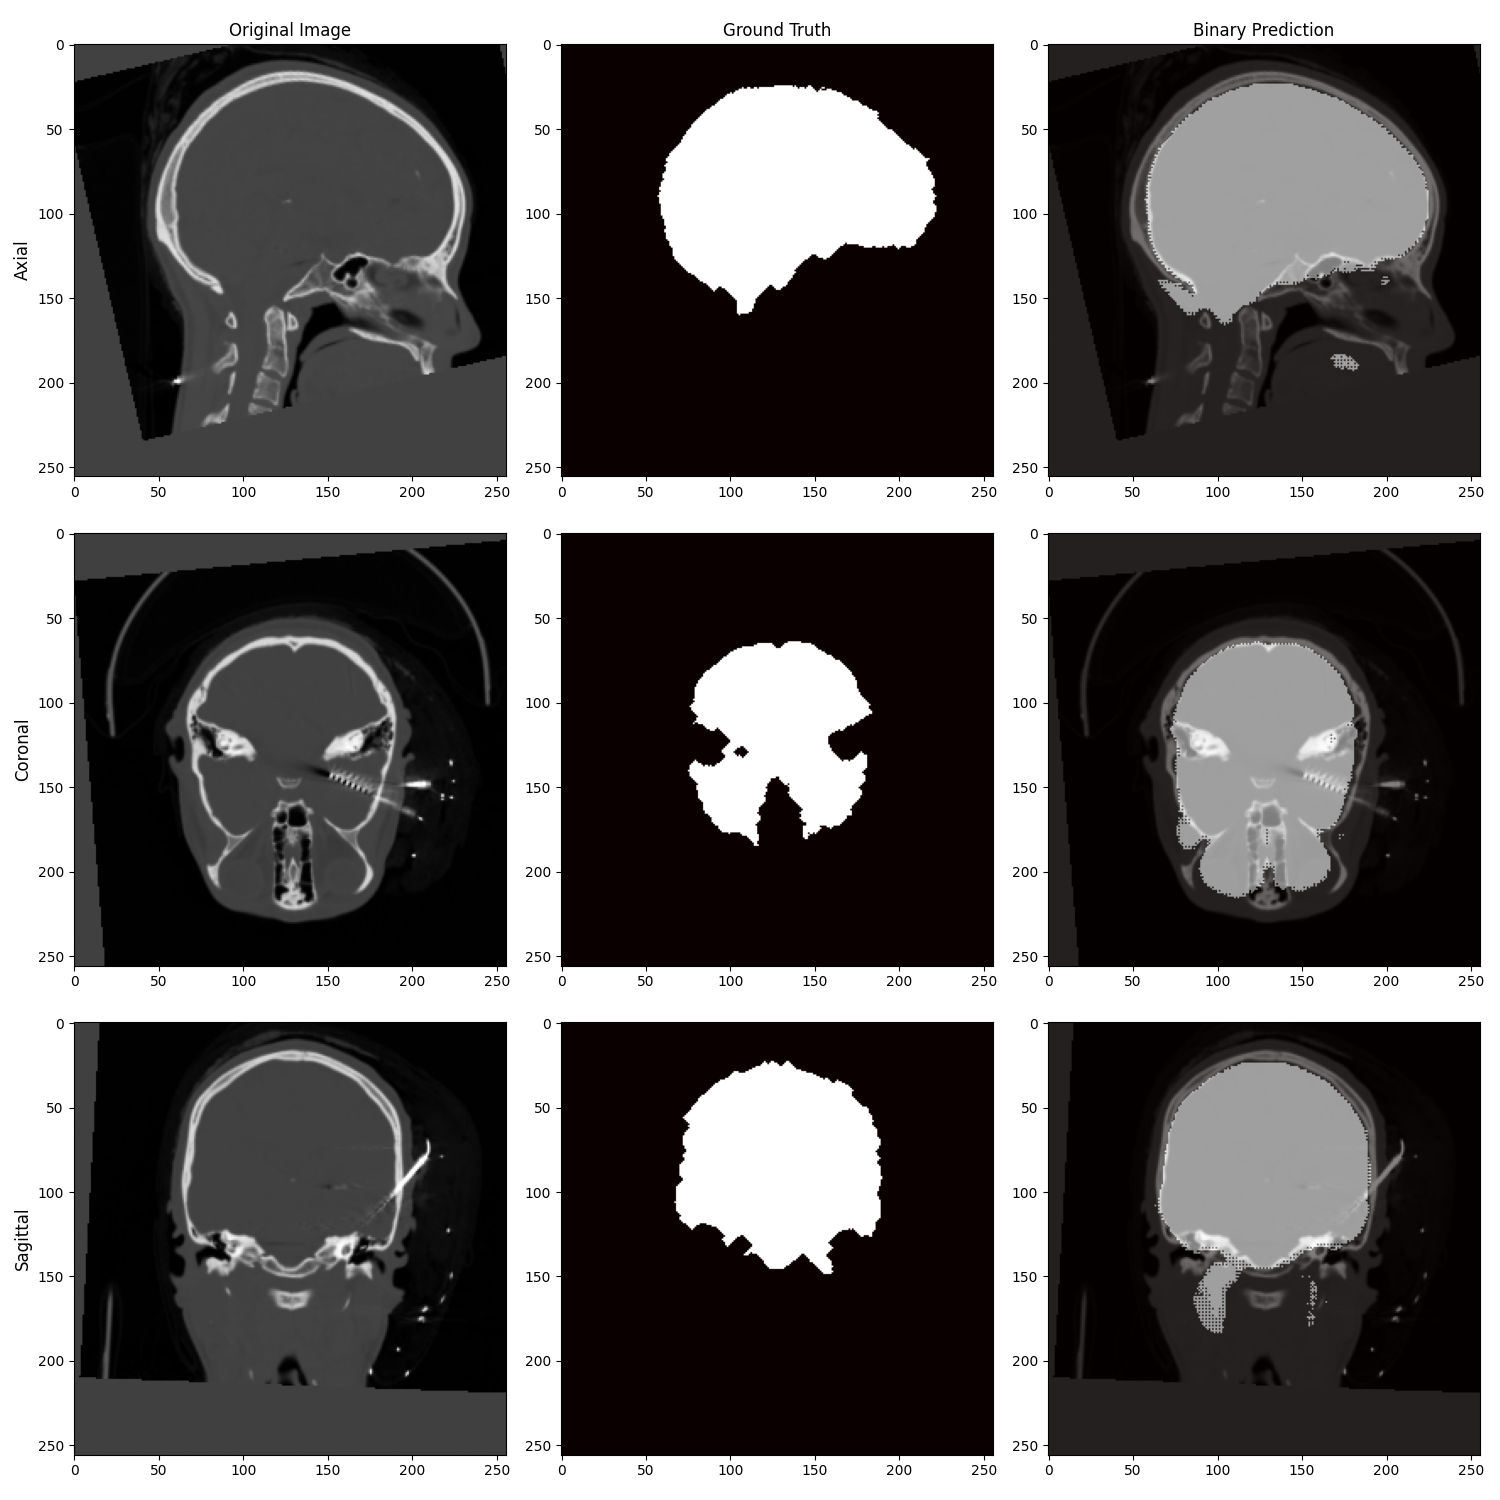

In [71]:
Image('/content/predictions_2_brain_mask/failure_analysis/patient_patient5_fold_0_epoch_0_binary.png')


## Training model with all patients

In [28]:
# 1. Load the checkpoint dictionary
checkpoint = torch.load("/content/predictions_2_brain_mask/best_model_fold_0_patient_patient1.pt")

# 2. Extract ONLY the model weights
model_weights = checkpoint["model_state_dict"]

# 3. Create model and load weights
final_model = create_model()
final_model.load_state_dict(model_weights)

# Train on 100% of data (including patient1)
full_dataset = BrainSegDataset(
    ct_path=ct_directory,
    mask_path=mask_directory,
    file_pairs=paired_files,
    transform=create_transforms(paired_files, ct_directory, is_train=True)
)

optimizer = optim.AdamW(final_model.parameters(), lr=1e-5)
loss_function = BinarySegLoss(dice_weight=0.8, bce_weight=0.2)
for epoch in range(20):
    train_epoch(final_model, DataLoader(full_dataset, batch_size=1), optimizer, loss_function, epoch)

torch.save(final_model.state_dict(), "final_model_all_data.pt")

Maximum volume shape: [256, 256, 256]


Epoch 19: 100%|██████████| 6/6 [00:10<00:00,  1.78s/it, loss=0.766]


In [35]:
for pid in ["patient1","patient2","patient3", "patient4", "patient5", "patient8"]:
    load_and_visualize_failures(
        patient_id=pid,
        ct_dir=ct_directory,
        mask_dir=mask_directory,
        model_path="/content/final_model_all_data.pt",
        paired_files=paired_files,
        output_dir="final_validation"
    )

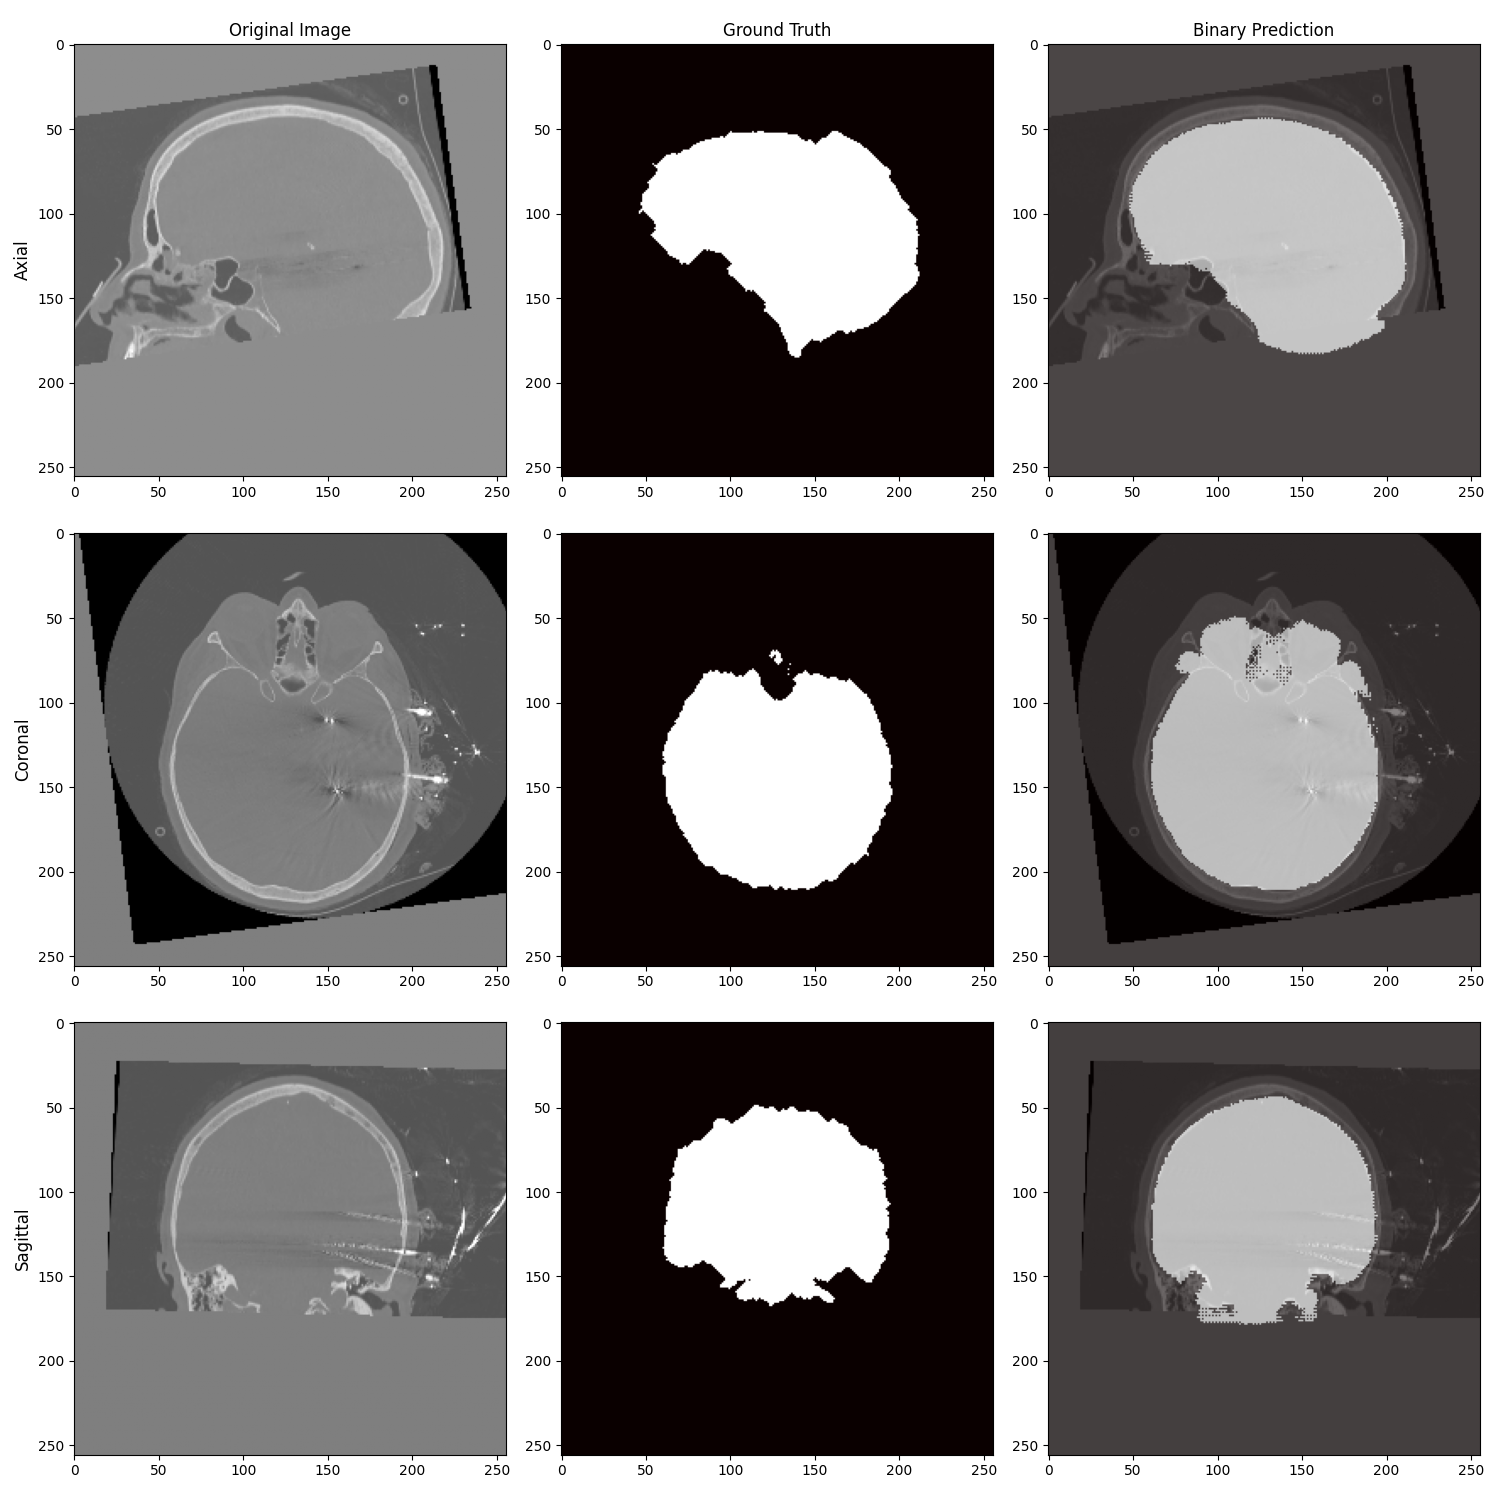

Binary mask prediction


In [49]:
from IPython.display import Image, display
def display_image(image_path, title):
    display(Image(image_path, width=700))
    print(title)
display_image('/content/final_validation/patient_patient3_fold_0_epoch_0_binary.png', 'Binary mask prediction')

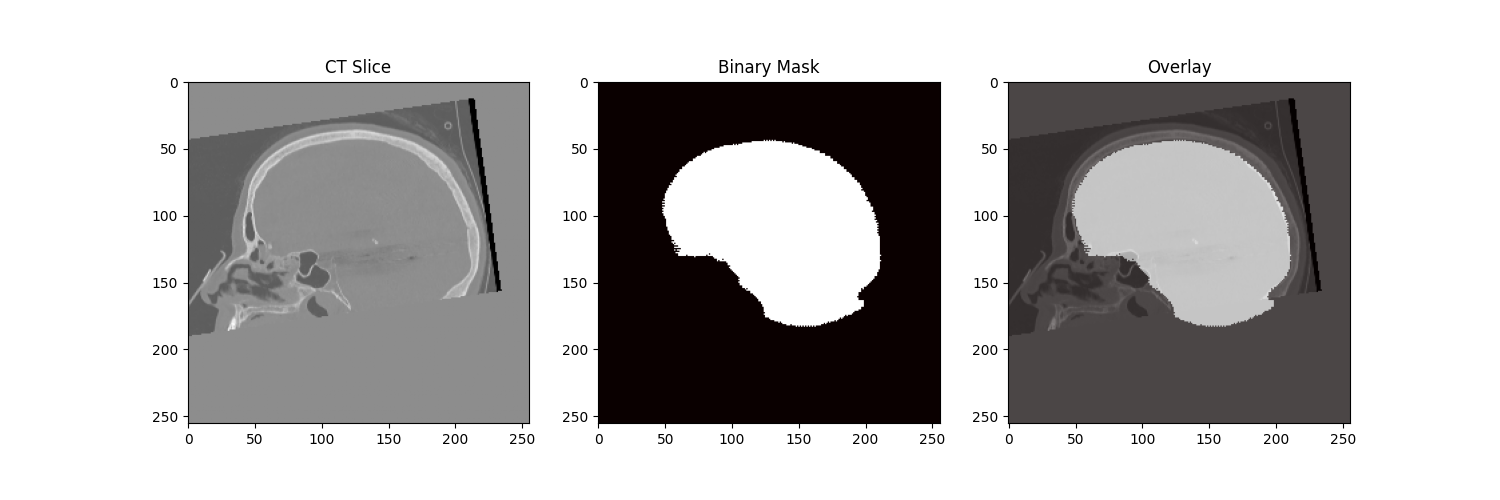

Comparison with ground truth


In [50]:
display_image('/content/final_validation/patient_patient3_fold_0_epoch_0_comparison.png', 'Comparison with ground truth')


## Prediction with CT not present in dataset


In [67]:
from monai.transforms import (
    Compose,
    Orientationd,
    ScaleIntensityRanged,
    SpatialPadd,
    ToTensord,
    EnsureChannelFirstd
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_preprocess_transforms():
    return Compose([
        EnsureChannelFirstd(keys="image", channel_dim='no_channel'),
        Orientationd(keys="image", axcodes="RAS"),
        ScaleIntensityRanged(
            keys="image",
            a_min=-1000,
            a_max=1000,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        SpatialPadd(
            keys="image",
            spatial_size=(256, 256, 192),
            mode="constant",
            value=0,
        ),
        ToTensord(keys="image")
    ])

def predict_ct(ct_path, model_path, output_dir):

    ct_data, header = nrrd.read(ct_path)
    original_shape = ct_data.shape
    input_data = {"image": ct_data}

    # Apply transforms
    transforms = get_preprocess_transforms()
    transformed = transforms(input_data)
    model = create_model()
    checkpoint = torch.load(model_path, map_location=device)

    model.load_state_dict(checkpoint)
    model.eval()

    # Predict
    with torch.no_grad():
        input_tensor = transformed["image"].unsqueeze(0).to(device)
        pred = torch.sigmoid(model(input_tensor))

    # Process output
    pred_mask = (pred > 0.5).cpu().numpy()[0,0]
    pred_mask = pred_mask[:, :, :original_shape[2]]

    # Post-processing
    final_mask = post_process_mask(pred_mask)

    # Save results
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.basename(ct_path).replace(".nrrd", "")
    nrrd.write(os.path.join(output_dir, f"{base_name}_mask.nrrd"), final_mask, header)

    # Generate visualization
    plot_slices(ct_data, final_mask, output_dir, base_name)

def post_process_mask(mask, min_size=1000):
    """Clean up small artifacts in 3D"""
    from scipy.ndimage import binary_fill_holes, label
    cleaned = binary_fill_holes(mask)
    labels, _ = label(cleaned)

    if labels.max() > 0:
        largest = np.argmax(np.bincount(labels.flat)[1:]) + 1
        cleaned = (labels == largest)

    return cleaned.astype(np.uint8)

def plot_slices(ct, mask, output_dir, name):
    """Generate orthogonal slice visualization"""
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Axial (Z-axis)
    z_slice = ct.shape[2] // 2
    ax[0].imshow(ct[:, :, z_slice], cmap='gray')
    ax[0].imshow(mask[:, :, z_slice], alpha=0.3, cmap='jet')
    ax[0].set_title(f"Axial Slice {z_slice}")

    # Coronal (Y-axis)
    y_slice = ct.shape[1] // 2
    ax[1].imshow(ct[:, y_slice, :].T, cmap='gray')
    ax[1].imshow(mask[:, y_slice, :].T, alpha=0.3, cmap='jet')
    ax[1].set_title(f"Coronal Slice {y_slice}")

    # Sagittal (X-axis)
    x_slice = ct.shape[0] // 2
    ax[2].imshow(ct[x_slice, :, :].T, cmap='gray')
    ax[2].imshow(mask[x_slice, :, :].T, alpha=0.3, cmap='jet')
    ax[2].set_title(f"Sagittal Slice {x_slice}")

    plt.savefig(os.path.join(output_dir, f"{name}_views.png"))
    plt.close()

if __name__ == "__main__":
    # Configuration
    ct_path = "/content/7_CTp.3D.nrrd"
    model_path = "/content/predictions_2_brain_mask/final_model_all_data.pt"
    output_dir = "predictions"

    # Run prediction
    predict_ct(ct_path, model_path, output_dir)
    print(f"Results saved to {output_dir}")

Results saved to predictions


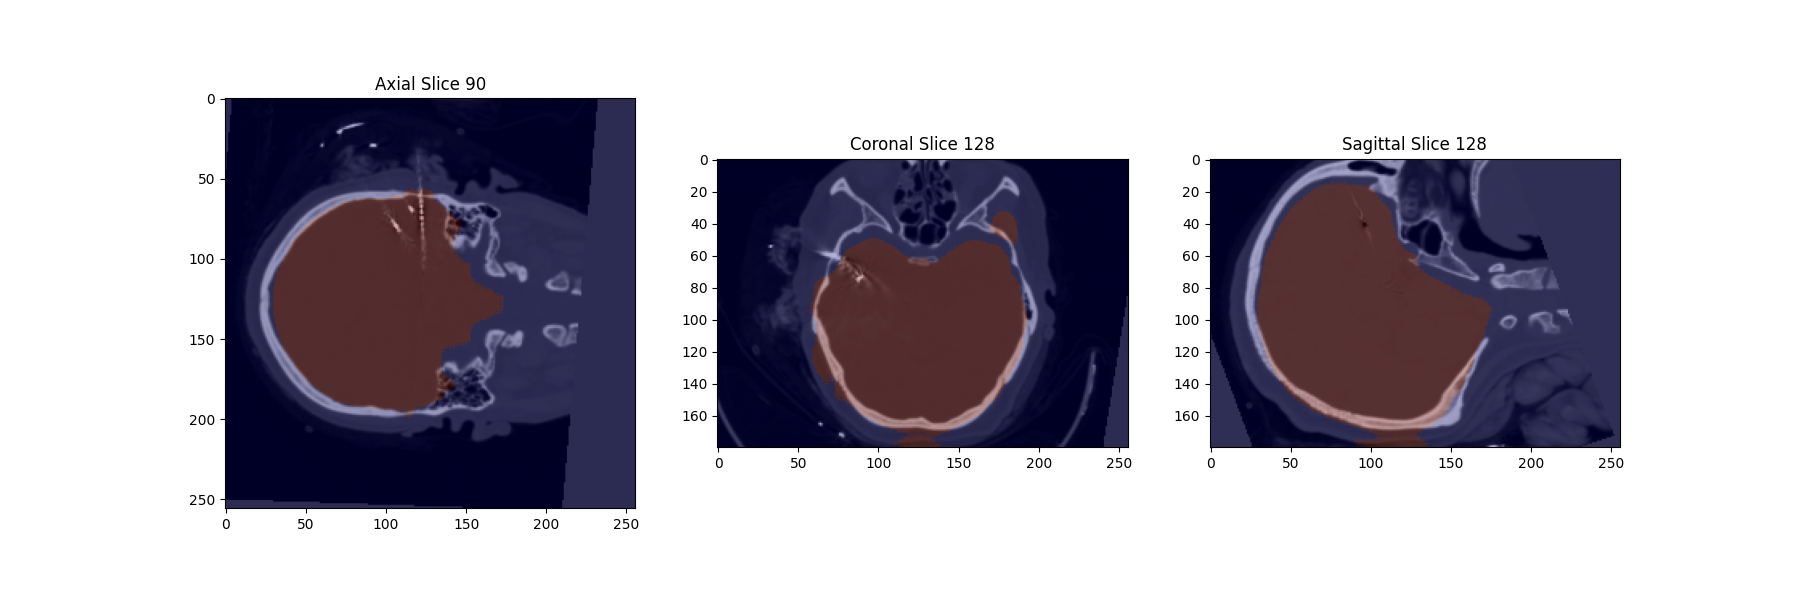

Prediction of brain mask in new CT scan


In [70]:
display_image('/content/predictions/7_CTp.3D_views.png', 'Prediction of brain mask in new CT scan')

In [72]:
# prompt: zip download /content/predictions

!zip -r /content/predictions_models_loocv.zip /content/predictions_2_brain_mask
from google.colab import files
files.download('/content/predictions_models_loocv.zip')


  adding: content/predictions_2_brain_mask/ (stored 0%)
  adding: content/predictions_2_brain_mask/patient_patient2_fold_1_epoch_29_comparison.png (deflated 5%)
  adding: content/predictions_2_brain_mask/patient_patient2_fold_1_epoch_19_comparison.png (deflated 5%)
  adding: content/predictions_2_brain_mask/patient_patient4_fold_3_epoch_14_comparison.png (deflated 4%)
  adding: content/predictions_2_brain_mask/patient_patient5_fold_4_epoch_24_comparison.png (deflated 6%)
  adding: content/predictions_2_brain_mask/best_model_fold_0_patient_patient1.pt (deflated 8%)
  adding: content/predictions_2_brain_mask/patient_patient2_fold_1_epoch_9_comparison.png (deflated 4%)
  adding: content/predictions_2_brain_mask/patient_patient2_fold_1_epoch_29_binary.png (deflated 3%)
  adding: content/predictions_2_brain_mask/patient_patient8_fold_5_epoch_4_comparison.png (deflated 6%)
  adding: content/predictions_2_brain_mask/patient_patient1_fold_0_epoch_39_binary.png (deflated 3%)
  adding: content/p

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>